# Falling Tablecloth

From our understanding of the Ising model, where we sampled the complex space of spins using the Metropolis-Hastings algorithm, we branch in two directions: 1) estimating probability distribution functions, and 2) simulated annealing. This example is drawn from the second, an optimization of a high-dimensional function using methods that are similar to the physics of slowly cooling hot matter. In spite of it seeming a stretch, it is closer to our Ising model than is the first, which requires generalization of the Boltzmann function and understanding of Bayes Theorem.

At a high level, the idea of simulated annealing is to take system that has many degrees of freedom, perturb one at random, and see how the energy changes as a result. The high degrees of freedom is important, there are many superior ways of optimizing functions of just a few variables. If the random change produces a lower energy ($\Delta E < 0$), accept the change, if the energy increases accept it with a probability proportional to the Boltzmann distribution; accept $\propto e^{-\frac{\Delta E}{kT}}$. Sound familiar? It should. When we apply this to a function, it's called ''simulated annealing'' because we find the minimum from 'cooling' the system. This suggests that now, in addition to accepting or rejecting proposals with the Boltzmann distribution, we also decrease $kT$, trying to allow the system to find its way to a lowest energy configuration.

To grasp the concept, maybe it will be easier to do this yourself. The following problem asks you to find the shape of a cloth that is supported at its corners, and is under the influence of gravity. The result has a nice visual interpretation that will aid your inquiry because you'll know what looks right.

#### The Change in Energy
As with any problem of this type, we begin by specifying an energy. Here, we imagine the tablecloth consists of lattice of masses connected by springs. All masses and spring are the same. The springs have an equilibrium length (length where springs exert no force) of $l$ and a spring constant $k$. If we move a particular particle a random amount $\Delta \mathbf{r} = (\Delta x, \Delta y, \Delta z)$ we get a new position $\mathbf{r}' = \mathbf{r} + \Delta\mathbf{r}$. The change in energy is computed from changes in spring lengths caused by moving the particle with respect to its four nearest neighbors, as well as changes in gravitational potential,
$$ \Delta E = -\frac{1}{2}k \sum_{i = nn} [(d'_i -l)^2 - (d_i-l)^2] + mg\Delta z.$$
Where $d'_i = |\mathbf{r}' - \mathbf{r}_i|$, the distance of the perturbed position and nearest neighbor $i$, and $d_i = |\mathbf{r} - \mathbf{r}_i|$ is the distance between the unperturbed particle and its neighbor $i$. The gravitational potential energy, or $mg\Delta z$ is included outside the sum as an additional term.

#### Problem Statement
Simulate the hanging tablecloth problem, and find the minimum energy by thermal relaxation. Assume that each of the four corners of the cloth are fixed at the same $z$ for the entire simulation and that the cloth is square.

a) Design a Metropolis updater using the formula above to find $\Delta E$. Monitor the energy as a function of MCMC steps. Assume the initial energy is zero, and keep track of total energy by summing the accepted $\Delta E$s. The shape of this curve should be evaluated to find when the function is minimized.

Convergence can be improved by selecting only a single direction to perturb in, and sampling more frequently in the $z$ direction, where potential energy can have a large impact on $\Delta E$. So, 25% of the time perturb in the $x$ direction, 25% in the $y$, and 50% in the $z$. The perturbations are going to be in space, and some normal distribution is the right choice. Let's increase the perturbation distribution by a factor of two in the $z$ direction so it is explored more aggressively. Something like the following in code:

In [87]:
import numpy as np
sigma = .25 # A choice of standard deviation for the random perturbations.
dx,dy,dz = 0,0,0
p = np.random.rand()
if p<.25:
    dx = np.random.randn() * sigma
elif p<.5:
    dy = np.random.randn() * sigma
else:
    dz = np.random.randn() * 2 * sigma

So that we all agree on the results, let's have the following set of values for $N$, $k$, $l$, $m$, $\sigma$, $g$, and $kT$.

In [88]:
N = 16 # Number of masses per side.
k=50   # Spring constant
l=1    # Spring equilibrium length
m=.04  # Mass, almost looks like a density in the limit of N -> inf
sigma = .25*l  # This is standard deviation of the gaussian region sampled for perturbations.
g = 9.8        # graviational acceleration, note sign!
kT = 1e-3      # Temparature appearing in Boltzmann factor, this should be changed through runs.

Run the simulation to equilibrium and plot the result. Try the `plot_wireframe` function. Begin with all positions of masses seperated by $l$ from nearest neighbors, and having the same $z$ coordinate. 

How did you determine the system was in equilibrium? Add this function to your code.

Repeat the experiment, but now include a ''cooling schedule''. Try halving the temperature each time the system reaches equilibrium. Do three successive halvings. Plot the different final configurations and comment on their differences.

(b) Plot the energy per particle vs the temperature at various lattice sizes. Explain what you find.


## (a)
---

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

class Cloth:

    def __init__(self, N=16):

        self.N = N              # Number of masses per side.
        self.k = 50             # Spring constant
        self.l = 1              # Spring equilibrium length
        self.m = 0.04           # Mass, almost looks like a density in the limit of N -> inf
        self.sigma = 0.0025     # This is standard deviation of the gaussian region sampled for perturbations.
        self.g = 9.8            # gravitational acceleration, note sign!
        self.kT = 1e-3          # Temperature appearing in Boltzmann factor, this should be changed through runs.
        self.E = 0
        self.step = 0


        self.cloth = self.initialize_cloth()
        self.fixed_points = {(0, 0),
                            (0, self.N - 1),
                            (self.N - 1, 0),
                            (self.N - 1, self.N - 1)
                            }

        self.energy_list = []

    def reset(self, N):
        """
        Reset simulation environment.
        :return: None
        """
        self.__init__(N=N)
        return None

    def initialize_cloth(self):
        l = np.zeros((self.N, self.N, 3))
        for i in range(self.N):
            for j in range(self.N):
                l[i][j] = np.array([i, j, 1])

        return l

    def do_mcmc_step(self):
        """
        Itterate through entire cloth to perform one MCMC step on each point.
        :return: None
        """
        # iterate through each point on the cloth
        for i in range(self.N):
            for j in range(self.N):
                # check for fixed points
                if (i, j) not in self.fixed_points:
                    dE, dr = self.perturb(point=(i, j))
                    # MCMC step
                    if dE < 0 or np.random.rand() < np.exp(-dE/self.kT):
                        # if self.step < 10:
                        #     print(dE)
                        self.cloth[i][j] += dr
                        self.E += dE
                    self.step += 1
                    self.energy_list.append(self.E)
        return None

    def perturb(self, point):
        """
        Purturb given point with random noise in one direction. Noise is applied in one direction with probability p.
        :param point: position to be perturbed (x,y)
        :return:
        """
        sigma = .25 # A choice of standard deviation for the random perturbations.
        dx,dy,dz = 0,0,0
        p = np.random.rand()
        if p < 0.25:
            dx = np.random.randn() * sigma
        elif p < 0.5:
            dy = np.random.randn() * sigma
        else:
            dz = np.random.randn() * 2 * sigma
        dr = np.array((dx,dy,dz))

        dE = self.calc_dE(point, dr)

        return dE, dr


    def calc_dE(self, point, dr):
        """
        Given a point and a change in position, calculate the change in energy.

        :param point: original position, (x, y, z)
        :param dr: change in position, (dx, dy, dz)
        :return: change in energy, dE
        """
        # get nearest neighbors, list of tuples
        nn = self.get_nearest_neighbors(point)

        # get original position and perturbed position
        original_position = self.cloth[point[0]][point[1]]
        perturb_pos = original_position + dr

        # initialize change in energy for summation
        inside_sum = 0
        for n in nn:
            # get position of nearest neighbor
            neighbor_pos = self.cloth[n[0]][n[1]]

            # calculate terms inside sum and add to running sum
            term1 = (np.linalg.norm(perturb_pos - neighbor_pos)-self.l)**2
            term2 = (np.linalg.norm(original_position - neighbor_pos)-self.l)**2
            inside_sum += term1 - term2

        # complete dE calculation by adjusting for spring constant and gravitational potential
        # equation proveded is wrong, eliminate the negative sign infront of the spring constant
        spring_potential = 0.5*self.k * inside_sum
        grav_potential = self.m * self.g * dr[2]

        dE = spring_potential + grav_potential

        return dE

    def get_nearest_neighbors(self, point: tuple):
        """
        From a given point, look for nearest neighbors and return thier cloth indexes in a list.
        :param point: point to find nearest neighbors from, (x,y)
        :return: list of nearest neighbors, (list:tuples)
        """
        nn = []
        # check up one row
        if point[0] - 1 >= 0:
            nn.append((point[0]-1, point[1]))

        # check down one row
        if point[0] + 1 < self.N:
            nn.append((point[0] + 1, point[1]))

        # check left one column
        if point[1] - 1 >= 0:
            nn.append((point[0], point[1] - 1))

        # check right one column
        if point[1] + 1 < self.N:
            nn.append((point[0], point[1] + 1))

        return nn

    def plot_cloth(self):
        """
        Plots wire frame of cloth at current state
        :return: None
        """

        x = self.cloth[:,:,0]
        y = self.cloth[:,:,1]
        z = self.cloth[:,:,2]

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(x, y, z)
        plt.show()

        return None


    def at_equilibrium(self):
        if self.step > 1000:
            prev_mean = np.mean(self.energy_list[-1000: -950])
            current_mean = np.mean(self.energy_list[-50:self.step])

            if prev_mean/current_mean % 1  < 0.001:
                return True

        return False

    def plot_energy(self):
        """
        Plots energy as a function of MCMC step.
        :return: None
        """
        plt.xlabel("MCMC Step")
        plt.ylabel("Energy")
        plt.plot(np.arange(self.step), self.energy_list)
        plt.show()

        print(f"Accepted Steps: {self.step}")

        return None

    def plot_particle_energy(self, lattice_sizes):
        """
        Plots energy per particle as function of MCMC step for each lattice size provided.
        :return: None
        """
        data = {}
        for size in lattice_sizes:
            self.reset(N=size)
            while self.step < 1e6:
                self.do_mcmc_step()

            data[size] = self.energy_list.copy()

        plt.xlabel("MCMC Step")
        plt.ylabel("Energy / Particle")
        for series in data:
            plt.plot(np.arange(len(data[series])), data[series], label=f"Lattice: {series}")

        plt.legend()
        plt.show()

        return None

# # for debugging purposes
# cloth = Cloth()
# cloth.plot_cloth()
#
# for _ in range(1000):
#     cloth.do_mcmc_step()


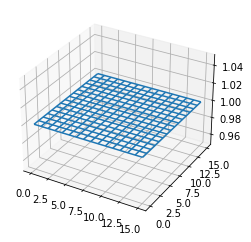

In [2]:
cloth = Cloth()
cloth.plot_cloth()

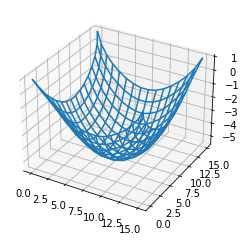

In [3]:
for _ in range(10000):
    cloth.do_mcmc_step()
cloth.plot_cloth()

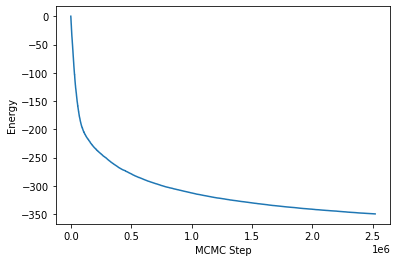

Accepted Steps: 2520000


In [4]:
cloth.plot_energy()

There appears to be an error in the energy equation provided:

$$ \Delta E = -\frac{1}{2}k \sum_{i = nn} [(d'_i -l)^2 - (d_i-l)^2] + mg\Delta z.$$

If we take a look at the spring energy term, we see that any perturbation with a position farther away from the
equilibrium spring distance than the previous position will yield a negative changes in energy for that term.
This does not make physical sense as we want to minimize the displacement from spring the equilibrium
distance. The negative sign therefore causes the system to diverge. Once removed the system operates as intended.


Equilibrium is defined as a change of less than 0.01% in mean energy from 1000-950 previous accepted energies, and the mean
 of the most recent 50 accepted energies. Equilibrium usually reached after ~1,000,000 steps.

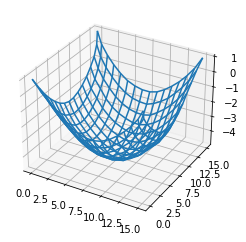

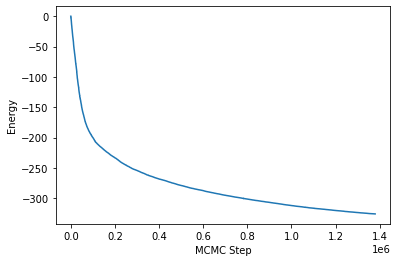

Accepted Steps: 1379196


In [5]:
cloth = Cloth()
while not cloth.at_equilibrium():
    cloth.do_mcmc_step()

cloth.plot_cloth()
cloth.plot_energy()



### cooling schedule


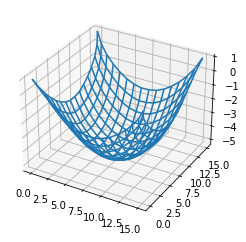

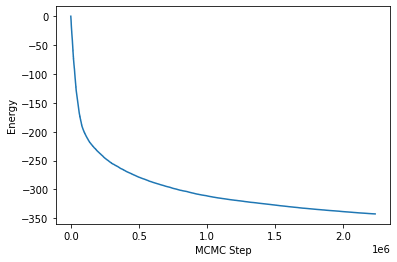

Accepted Steps: 2236752


In [9]:
cloth = Cloth()
for _ in range(3):
    # do 1000 steps so that equilibrium windows do not overlap
    for _ in range(1000):
        cloth.do_mcmc_step()

    while not cloth.at_equilibrium():
        cloth.do_mcmc_step()

    cloth.kT = cloth.kT / 2


cloth.plot_cloth()

cloth.plot_energy()

## (b)
---

As the lattice size the equilibrium energy per particle decreases. This intuitively makes sense as a larger lattice can
sag more resulting in a lower energy per a particle than a smaller lattice.


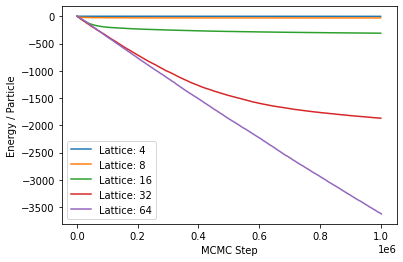

In [12]:
cloth = Cloth()
cloth.plot_particle_energy(lattice_sizes=[4, 8, 16, 32, 64])

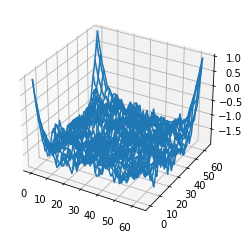

In [13]:
cloth.plot_cloth()
